In [1]:
from libraries import lib
from libraries.NeuralStates import *
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from scipy import stats

In [2]:
N = 2
J = 1
Gamma = 1

In [3]:
def amp_phase(nn_output):
    return nn_output[:, 0] * torch.exp(1.j * 2 * np.pi * nn_output[:, 1])
def normal_x(x, sigma, bounds = (float('-inf'), float('inf'))):
    new_x = round(npr.normal(x, sigma)) % (bounds[1] + 1)
    return new_x
def uniform_x(min, max):
    return npr.randint(min, max + 1)
def bitflip_x(x, N, flips):
    new_x = x
    for _ in range(flips):
        new_x = x ^ (1 << npr.randint(0, N))
    return new_x

In [4]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)

In [5]:
input = lib.generate_input_torch(N)
model_state = lib.model_to_ground_state(model, input, amp_phase)
model_state = np.squeeze(model_state.full())

In [6]:
model_MH = MHNeuralState(N, model, amp_phase, 
                         lambda x : bitflip_x(x, N, 1), 1, 10, lag = 0)

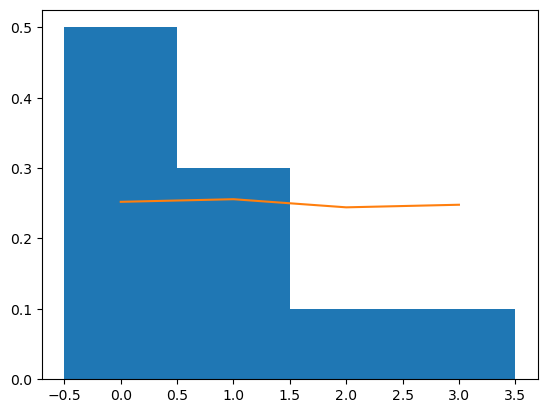

In [7]:
hist = plt.hist(model_MH.distribution_to_list(), density = True, bins = [-0.5 + n for n in range(0, 2 ** N + 1)])
model_distr = np.abs(model_state) ** 2
plt.plot([n for n in range(0, 2 ** N)], model_distr)
plt.show()

In [8]:
def calc_dist(v1, v2):
    return sum(abs(v1[i] - v2[i]) ** 2 for i in range(len(v1)))

In [9]:
calc_dist(model_MH.to_prob_distribution(N), model_distr)

np.float64(5.126309463260483e-15)

In [10]:
calc_dist(model_MH.to_dense_vector(N), model_state)

np.float64(3.5561831257524545e-15)

In [11]:
model_MH.normalize()
print(calc_dist(model_MH.to_prob_distribution(N), model_distr))

tensor(4.6629e-15, grad_fn=<AddBackward0>)


In [12]:
samples = [n for n in range(5, 105, 5)]
dists = []
for num_samples in samples:
    model_MH = MHNeuralState(N, model, amp_phase, 
                         lambda x : bitflip_x(x, N, 1), 1, num_samples, lag = 0)
    # model_MH.normalize()
    dists.append(calc_dist(model_MH.to_prob_distribution(N), model_distr).item())

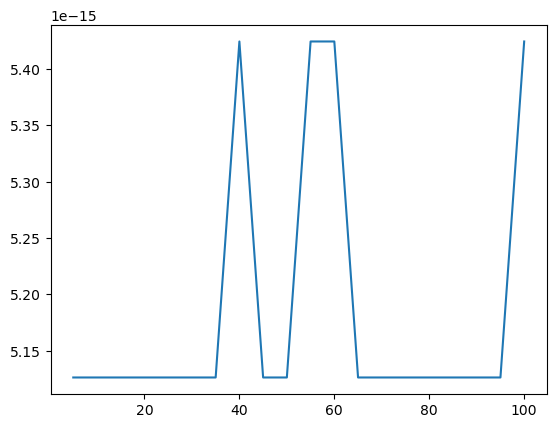

In [13]:
plt.plot(samples, dists)
plt.show()

In [14]:
N = 12
J = 1
Gamma = 1

In [15]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)
input = lib.generate_input_torch(N)
model_state = lib.model_to_ground_state(model, input, amp_phase)
model_state = np.squeeze(model_state.full())
model_distr = np.abs(model_state) ** 2

In [16]:
samples = [n for n in range(10, 500, 10)]
n_prob_dists = []
n_vector_dists = []
for num_samples in samples:
    model_MH = MHNeuralState(N, model, amp_phase, 
                         lambda x : normal_x(x, 20, (0, 2 ** N - 1)), 1, num_samples, lag = 0)
    n_prob_dists.append(calc_dist(model_MH.to_prob_distribution(N), model_distr).item())
    n_vector_dists.append(calc_dist(model_MH.to_dense_vector(N), model_state))

In [17]:
samples = [n for n in range(10, 500, 10)]
b_prob_dists = []
b_vector_dists = []
for num_samples in samples:
    model_MH = MHNeuralState(N, model, amp_phase, 
                         lambda x : bitflip_x(x, N, 1), 1, num_samples, lag = 0)
    b_prob_dists.append(calc_dist(model_MH.to_prob_distribution(N), model_distr).item())
    b_vector_dists.append(calc_dist(model_MH.to_dense_vector(N), model_state))

In [18]:
samples = [n for n in range(10, 500, 10)]
u_prob_dists = []
u_vector_dists = []
for num_samples in samples:
    model_MH = MHNeuralState(N, model, amp_phase, 
                         lambda x : uniform_x(0, 2 ** N - 1), 1, num_samples, lag = 0)
    u_prob_dists.append(calc_dist(model_MH.to_prob_distribution(N), model_distr).item())
    u_vector_dists.append(calc_dist(model_MH.to_dense_vector(N), model_state))

In [19]:
res = stats.linregress(np.log(samples), np.log(n_prob_dists))
print(res.rvalue)
res = stats.linregress(np.log(samples), np.log(b_prob_dists))
print(res.rvalue)
res = stats.linregress(np.log(samples), np.log(u_prob_dists))
print(res.rvalue)

-0.9914568853627966
-0.9990617113382149
-0.9998992698820875


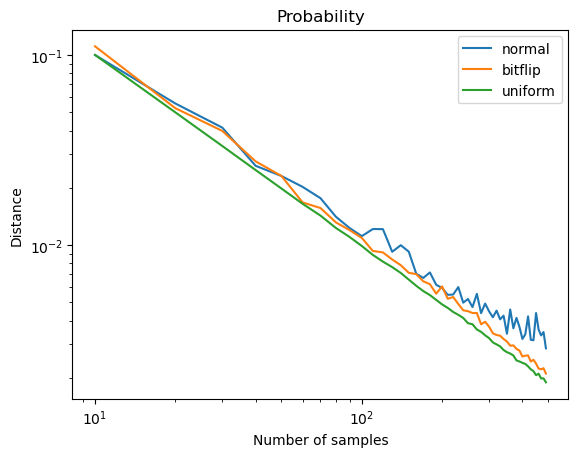

In [20]:
plt.plot(samples, n_prob_dists, label = 'normal')
plt.plot(samples, b_prob_dists, label = 'bitflip')
plt.plot(samples, u_prob_dists, label = 'uniform')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of samples')
plt.ylabel('Distance')
plt.title('Probability')
plt.legend(loc = 'best')
plt.show()

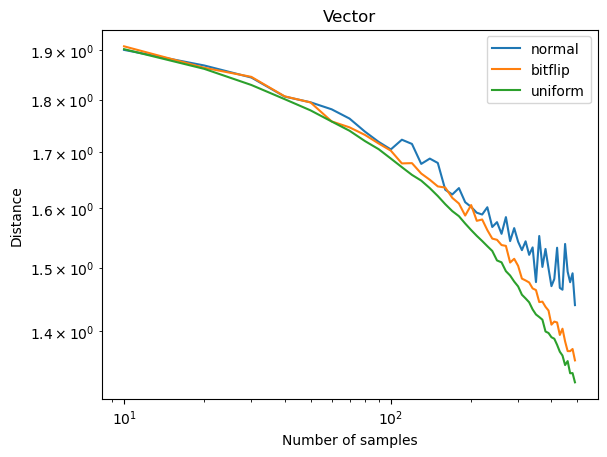

In [21]:
plt.plot(samples, n_vector_dists, label = 'normal')
plt.plot(samples, b_vector_dists, label = 'bitflip')
plt.plot(samples, u_vector_dists, label = 'uniform')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of samples')
plt.ylabel('Distance')
plt.title('Vector')
plt.legend(loc = 'best')
plt.show()

In [22]:
%%timeit
x = MHNeuralState(N, model, amp_phase, lambda x: uniform_x(0, 2 ** N - 1), 1, 500)

99.5 ms ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
%%timeit 
x = MHNeuralState(N, model, amp_phase, lambda x : bitflip_x(x, N, 1), 1, 500)

76.5 ms ± 5.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
%%timeit 
x = UniformNeuralState(N, model, amp_phase, 500)

43.2 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
N = 8
J = 1
Gamma = 1
input = lib.generate_input_torch(N)
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)

In [26]:
lib.train_model_to_gs(model, 
                      lambda model : model(input), 
                      lambda nn_output : lib.TFIM_expectation_from_torch(nn_output, (N, J, Gamma), amp_phase), 
                      1000, data_rate = 100)

([0, 100, 200, 300, 400, 500, 600, 700, 800, 900],
 [-7.99016809463501,
  -10.09723949432373,
  -10.114718437194824,
  -10.134834289550781,
  -10.109498023986816,
  -10.122472763061523,
  -10.132969856262207,
  -10.13533878326416,
  -10.136670112609863,
  -10.13723373413086])

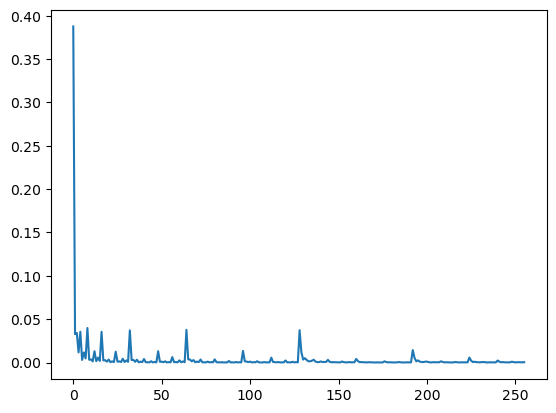

In [27]:
gs = lib.model_to_ground_state(model, lib.generate_input_torch(N), amp_phase)
gs = np.squeeze(gs.full())
plt.plot([n for n in range(0, 2 ** N)], np.abs(gs) ** 2)
plt.show()

In [28]:
lib.TFIM_expectation_from_torch(model(input), (N, J, Gamma), amp_phase)

tensor(-10.1395, grad_fn=<DivBackward0>)

In [29]:
lib.TFIM_hamiltonian(N, J, Gamma).eigenstates()[0][0]

np.float64(-10.251661790966022)

In [30]:
samples = [n for n in range(1, 128, 3)]

In [31]:
n_prob_dists = []
n_vector_dists = []
for num_samples in samples:
    model_MH = MHNeuralState(N, model, amp_phase, 
                         lambda x : normal_x(x, 5, (0, 2 ** N - 1)), 1, num_samples, lag = 0)
    n_prob_dists.append(calc_dist(model_MH.to_prob_distribution(N), model_distr).item())
    n_vector_dists.append(calc_dist(model_MH.to_dense_vector(N), model_state))

In [32]:
b_prob_dists = []
b_vector_dists = []
for num_samples in samples:
    model_MH = MHNeuralState(N, model, amp_phase, 
                         lambda x : bitflip_x(x, N, 1), 1, num_samples, lag = 0)
    b_prob_dists.append(calc_dist(model_MH.to_prob_distribution(N), model_distr).item())
    b_vector_dists.append(calc_dist(model_MH.to_dense_vector(N), model_state))

In [33]:
u_prob_dists = []
u_vector_dists = []
for num_samples in samples:
    model_MH = MHNeuralState(N, model, amp_phase, 
                         lambda x : uniform_x(0, 2 ** N - 1), 1, num_samples, lag = 0)
    u_prob_dists.append(calc_dist(model_MH.to_prob_distribution(N), model_distr).item())
    u_vector_dists.append(calc_dist(model_MH.to_dense_vector(N), model_state))

In [34]:
res = stats.linregress(np.log(samples), np.log(n_prob_dists))
print(res.rvalue)
res = stats.linregress(np.log(samples), np.log(b_prob_dists))
print(res.rvalue)
res = stats.linregress(np.log(samples), np.log(u_prob_dists))
print(res.rvalue)

-0.2922233124429486
-0.8225021689758861
-0.6258230080107497


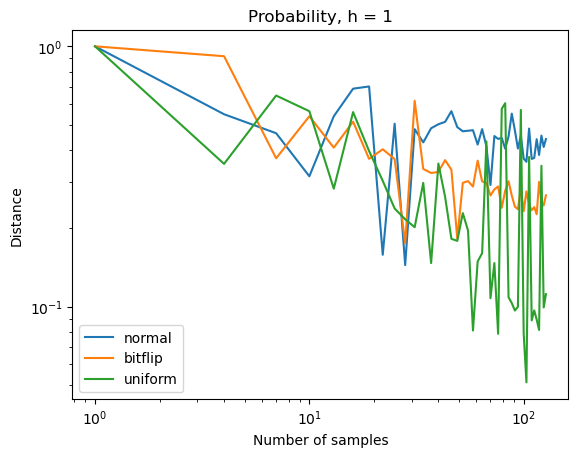

In [35]:
plt.plot(samples, n_prob_dists, label = 'normal')
plt.plot(samples, b_prob_dists, label = 'bitflip')
plt.plot(samples, u_prob_dists, label = 'uniform')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of samples')
plt.ylabel('Distance')
plt.title('Probability, h = 1')
plt.legend(loc = 'best')
plt.show()

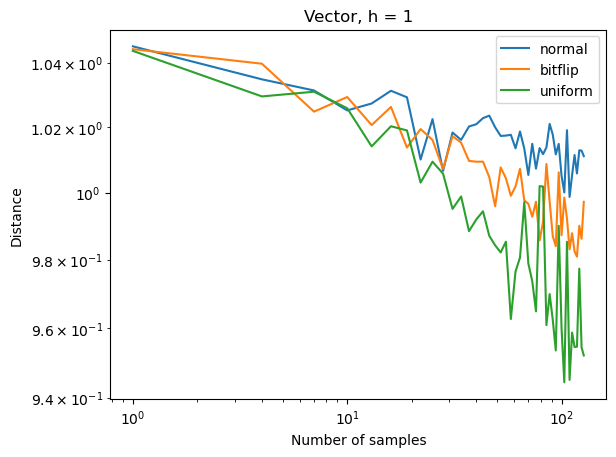

In [36]:
plt.plot(samples, n_vector_dists, label = 'normal')
plt.plot(samples, b_vector_dists, label = 'bitflip')
plt.plot(samples, u_vector_dists, label = 'uniform')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of samples')
plt.ylabel('Distance')
plt.title('Vector, h = 1')
plt.legend(loc = 'best')
plt.show()

In [37]:
N = 8
J = 1
Gamma = 0.1
input = lib.generate_input_torch(N)
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)

In [38]:
lib.train_model_to_gs(model, 
                      lambda model : model(input), 
                      lambda nn_output : lib.TFIM_expectation_from_torch(nn_output, (N, J, Gamma), amp_phase), 
                      1000, data_rate = 100)

([0, 100, 200, 300, 400, 500, 600, 700, 800, 900],
 [-0.7991475462913513,
  -8.019987106323242,
  -8.019989967346191,
  -8.019993782043457,
  -8.019990921020508,
  -8.019991874694824,
  -8.01999282836914,
  -8.019993782043457,
  -8.01999282836914,
  -8.019993782043457])

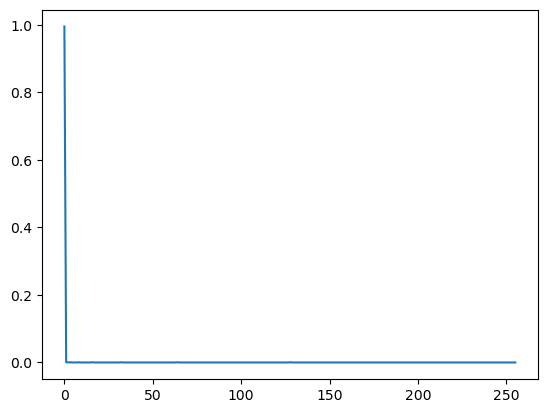

In [39]:
gs = lib.model_to_ground_state(model, lib.generate_input_torch(N), amp_phase)
gs = np.squeeze(gs.full())
gs_distr = np.abs(gs) ** 2
plt.plot([n for n in range(0, 2 ** N)], np.abs(gs) ** 2)
plt.show()

In [40]:
lib.TFIM_expectation_from_torch(model(input), (N, J, Gamma), amp_phase)

tensor(-8.0200, grad_fn=<DivBackward0>)

In [41]:
lib.TFIM_hamiltonian(N, J, Gamma).eigenstates()[0][0]

np.float64(-8.020012533458656)

In [42]:
samples = [n for n in range(1, 128, 3)]

In [43]:
n_prob_dists = []
n_vector_dists = []
for num_samples in samples:
    model_MH = MHNeuralState(N, model, amp_phase, 
                         lambda x : normal_x(x, 5, (0, 2 ** N - 1)), 1, num_samples, lag = 0)
    n_prob_dists.append(calc_dist(model_MH.to_prob_distribution(N), gs_distr).item())
    n_vector_dists.append(calc_dist(model_MH.to_dense_vector(N), gs))

In [44]:
b_prob_dists = []
b_vector_dists = []
for num_samples in samples:
    model_MH = MHNeuralState(N, model, amp_phase, 
                         lambda x : bitflip_x(x, N, 1), 1, num_samples, lag = 0)
    b_prob_dists.append(calc_dist(model_MH.to_prob_distribution(N), gs_distr).item())
    b_vector_dists.append(calc_dist(model_MH.to_dense_vector(N), gs))

In [45]:
u_prob_dists = []
u_vector_dists = []
for num_samples in samples:
    model_MH = MHNeuralState(N, model, amp_phase, 
                         lambda x : uniform_x(0, 2 ** N - 1), 1, num_samples, lag = 0)
    u_prob_dists.append(calc_dist(model_MH.to_prob_distribution(N), gs_distr).item())
    u_vector_dists.append(calc_dist(model_MH.to_dense_vector(N), gs))

In [46]:
res = stats.linregress(np.log(samples), np.log(n_prob_dists))
print(res.rvalue)
res = stats.linregress(np.log(samples), np.log(b_prob_dists))
print(res.rvalue)
res = stats.linregress(np.log(samples), np.log(u_prob_dists))
print(res.rvalue)

-0.5605408206488411
-0.9061024482347451
-0.37381423985370266


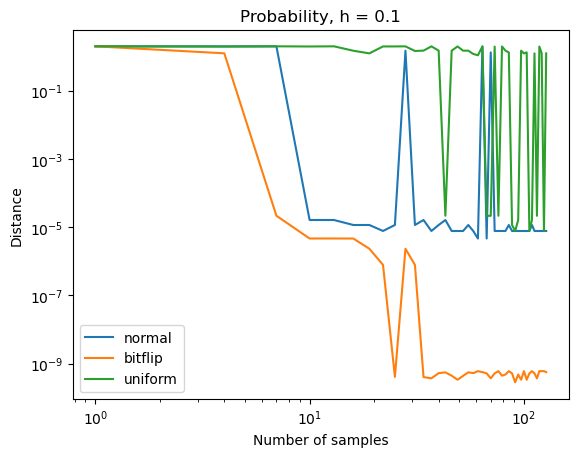

In [47]:
plt.plot(samples, n_prob_dists, label = 'normal')
plt.plot(samples, b_prob_dists, label = 'bitflip')
plt.plot(samples, u_prob_dists, label = 'uniform')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of samples')
plt.ylabel('Distance')
plt.title('Probability, h = 0.1')
plt.legend(loc = 'best')
plt.show()

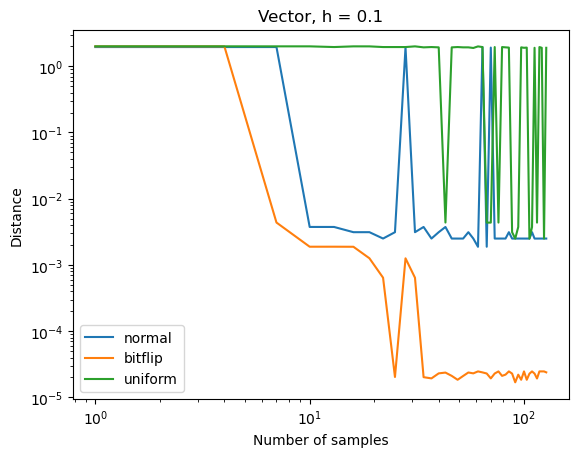

In [48]:
plt.plot(samples, n_vector_dists, label = 'normal')
plt.plot(samples, b_vector_dists, label = 'bitflip')
plt.plot(samples, u_vector_dists, label = 'uniform')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of samples')
plt.ylabel('Distance')
plt.title('Vector, h = 0.1')
plt.legend(loc = 'best')
plt.show()

In [49]:
N = 8
J = 1
Gamma = 10
input = lib.generate_input_torch(N)
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)

In [50]:
lib.train_model_to_gs(model, 
                      lambda model : model(input), 
                      lambda nn_output : lib.TFIM_expectation_from_torch(nn_output, (N, J, Gamma), amp_phase), 
                      1000, data_rate = 100)

([0, 100, 200, 300, 400, 500, 600, 700, 800, 900],
 [-79.76034545898438,
  -80.03450775146484,
  -79.99992370605469,
  -80.00043487548828,
  -79.99991607666016,
  -79.99992370605469,
  -79.99992370605469,
  -79.99992370605469,
  -79.99992370605469,
  -79.99992370605469])

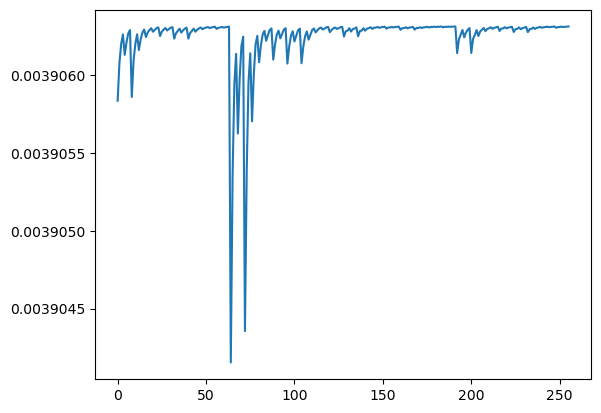

In [51]:
gs = lib.model_to_ground_state(model, lib.generate_input_torch(N), amp_phase)
gs = np.squeeze(gs.full())
gs_distr = np.abs(gs) ** 2
plt.plot([n for n in range(0, 2 ** N)], np.abs(gs) ** 2)
plt.show()

In [52]:
lib.TFIM_expectation_from_torch(model(input), (N, J, Gamma), amp_phase)

tensor(-79.9999, grad_fn=<DivBackward0>)

In [53]:
lib.TFIM_hamiltonian(N, J, Gamma).eigenstates()[0][0]

np.float64(-80.20012533458659)

In [54]:
samples = [n for n in range(1, 128, 3)]

In [55]:
n_prob_dists = []
n_vector_dists = []
for num_samples in samples:
    model_MH = MHNeuralState(N, model, amp_phase, 
                         lambda x : normal_x(x, 5, (0, 2 ** N - 1)), 1, num_samples, lag = 0)
    n_prob_dists.append(calc_dist(model_MH.to_prob_distribution(N), gs_distr).item())
    n_vector_dists.append(calc_dist(model_MH.to_dense_vector(N), gs))

In [56]:
b_prob_dists = []
b_vector_dists = []
for num_samples in samples:
    model_MH = MHNeuralState(N, model, amp_phase, 
                         lambda x : bitflip_x(x, N, 1), 1, num_samples, lag = 0)
    b_prob_dists.append(calc_dist(model_MH.to_prob_distribution(N), gs_distr).item())
    b_vector_dists.append(calc_dist(model_MH.to_dense_vector(N), gs))

In [57]:
u_prob_dists = []
u_vector_dists = []
for num_samples in samples:
    model_MH = MHNeuralState(N, model, amp_phase, 
                         lambda x : uniform_x(0, 2 ** N - 1), 1, num_samples, lag = 0)
    u_prob_dists.append(calc_dist(model_MH.to_prob_distribution(N), gs_distr).item())
    u_vector_dists.append(calc_dist(model_MH.to_dense_vector(N), gs))

In [58]:
res = stats.linregress(np.log(samples), np.log(n_prob_dists))
print(res.rvalue)
res = stats.linregress(np.log(samples), np.log(b_prob_dists))
print(res.rvalue)
res = stats.linregress(np.log(samples), np.log(u_prob_dists))
print(res.rvalue)

-0.9801091112579714
-0.993687110938418
-0.9990959412691861


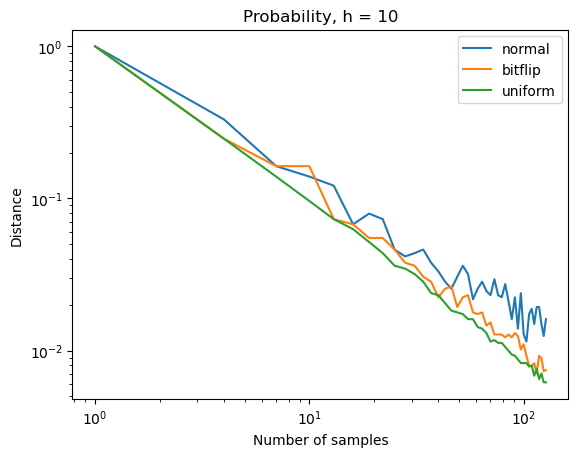

In [59]:
plt.plot(samples, n_prob_dists, label = 'normal')
plt.plot(samples, b_prob_dists, label = 'bitflip')
plt.plot(samples, u_prob_dists, label = 'uniform')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of samples')
plt.ylabel('Distance')
plt.title('Probability, h = 10')
plt.legend(loc = 'best')
plt.show()

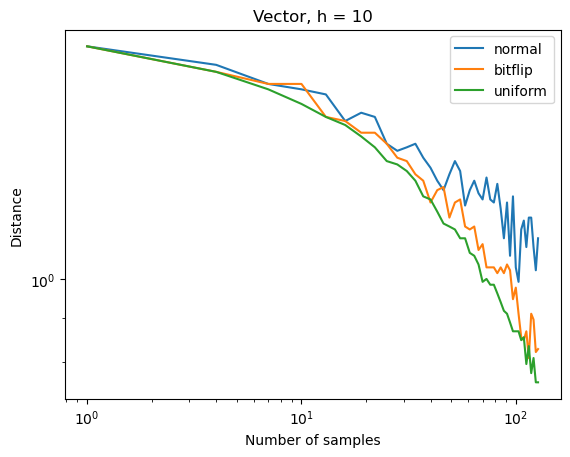

In [60]:
plt.plot(samples, n_vector_dists, label = 'normal')
plt.plot(samples, b_vector_dists, label = 'bitflip')
plt.plot(samples, u_vector_dists, label = 'uniform')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of samples')
plt.ylabel('Distance')
plt.title('Vector, h = 10')
plt.legend(loc = 'best')
plt.show()